In [91]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import scipy.stats
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 15)})

from tqdm.notebook import tqdm
tqdm().pandas()


# Load in the acousticbrainz dataset into the variable 'acousticbrainz'
acousticbrainz = pd.read_hdf(Path.cwd() / 'datasets' / 'acousticbrainzV2.h5')

# Pooled variance metric
def get_variance(df):
    variances = df.groupby(level=0).var()
    samplesizes = df.groupby(level=0).size()
    
    a = variances.loc[variances.index.repeat(samplesizes)].reset_index(drop=True)
    return a

# Pooled variance metric with filtering
def get_variance_filt(df):
    filt = df.groupby(level=0).size() > 1
    filtered = df[filt[df.index.get_level_values(level=0)].values]
    return get_variance(filtered)

Since it appeared (notebook 'Effect of audio quality on stability.ipynb') that the audio quality can have a large influence on the stability of the classifier, it is also interesting to see if the codec has an effect on the stability. First we will look at the stability accross codecs. To make sure that the codec is the only factor we are studying, we compare the codecs for the same bit rates.

These comparisons are not really fair, codecs with way more submissions have a larger probability of having more variance, thus we can take the same approach as above, but downsample so that the amount of samples per codec is the same

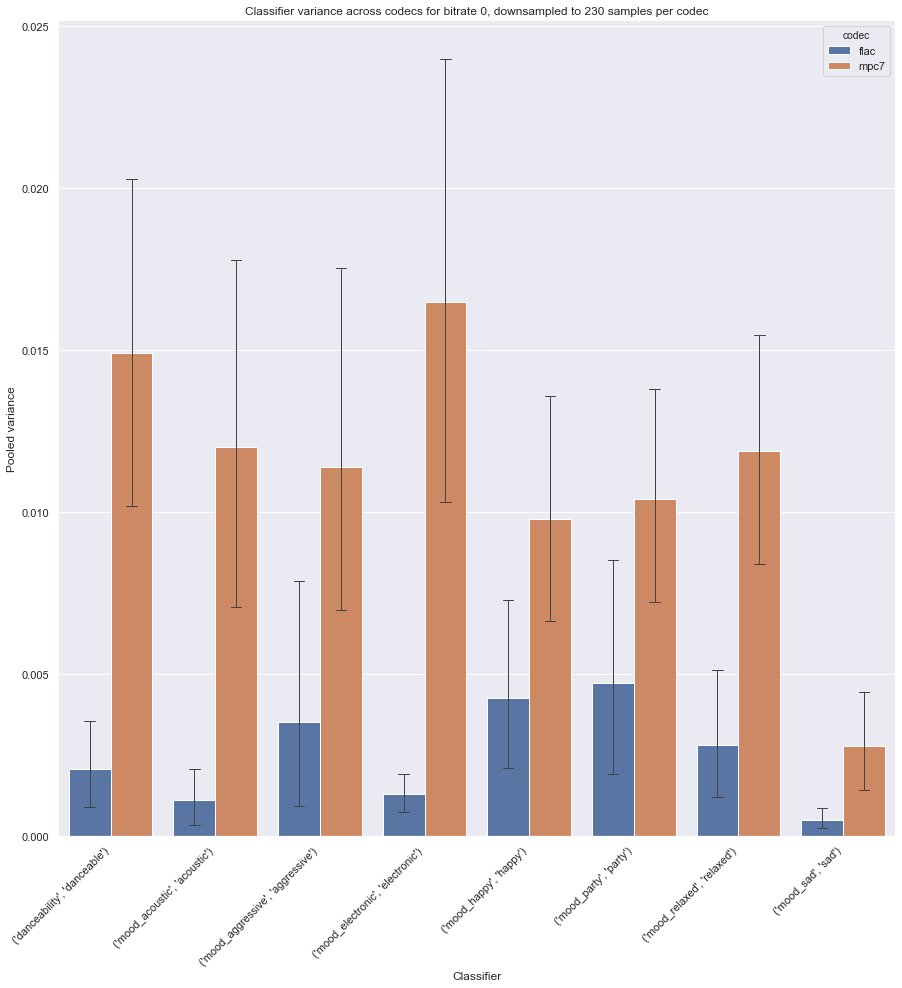

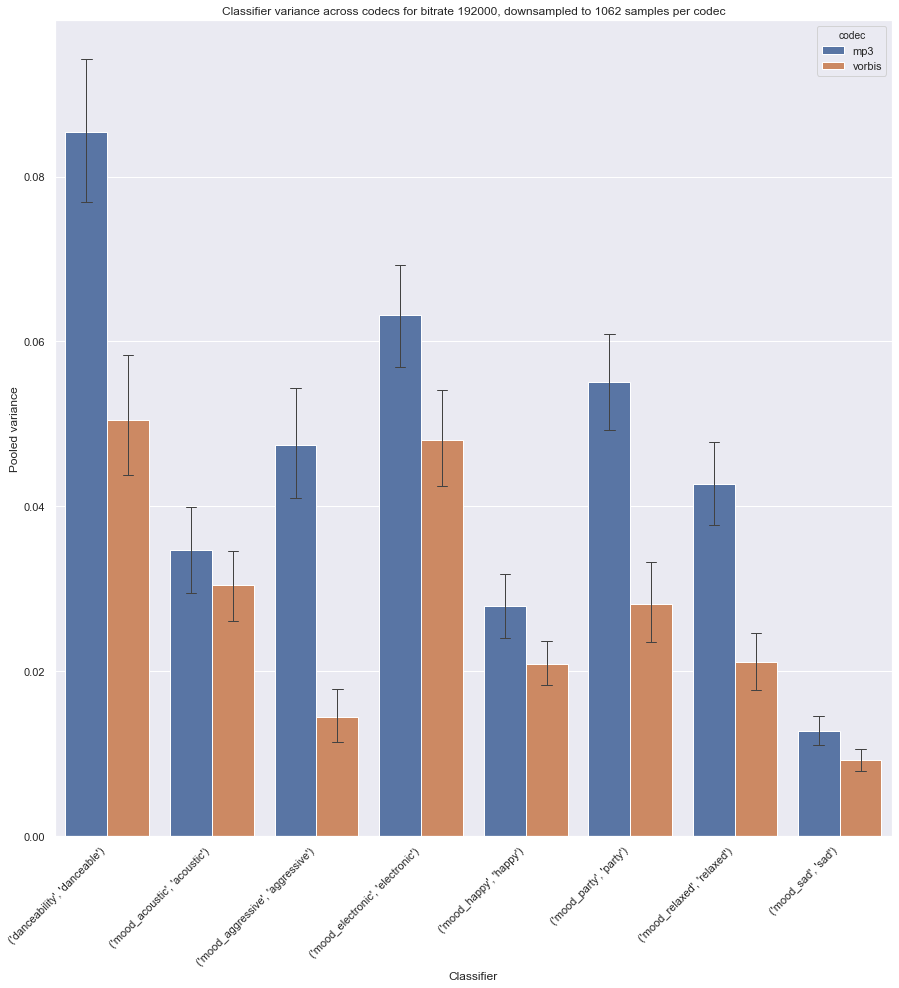

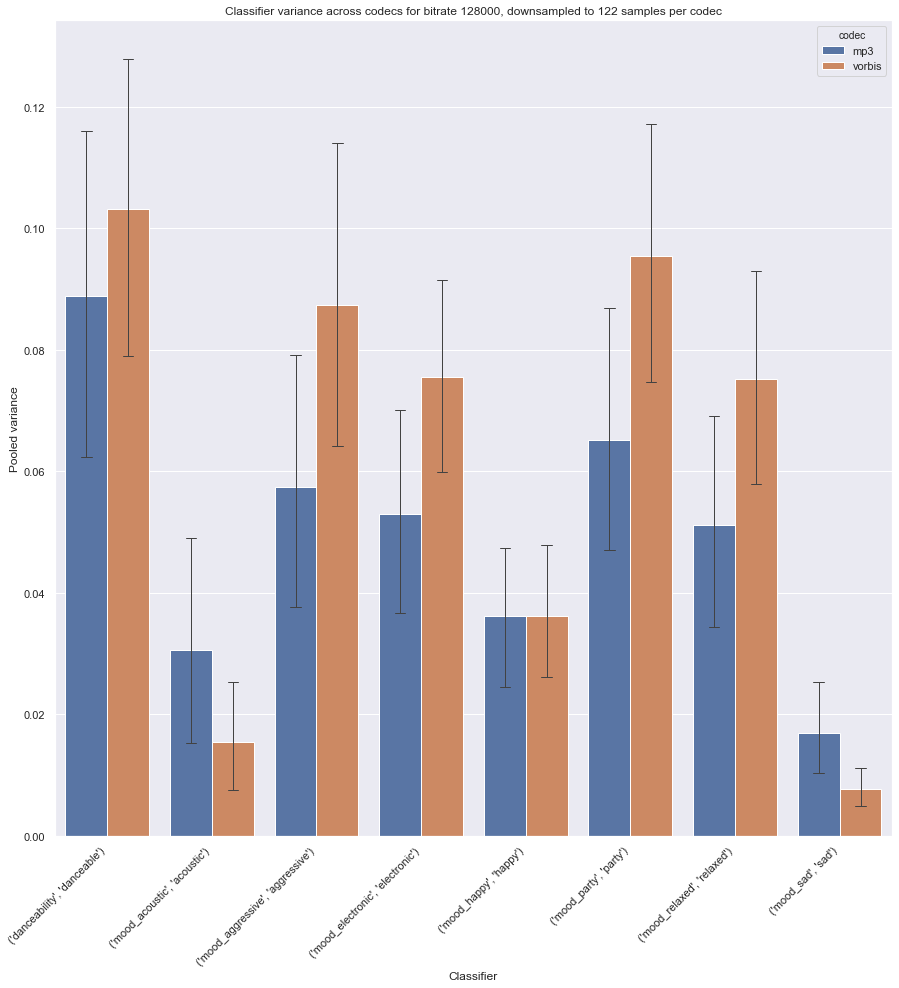

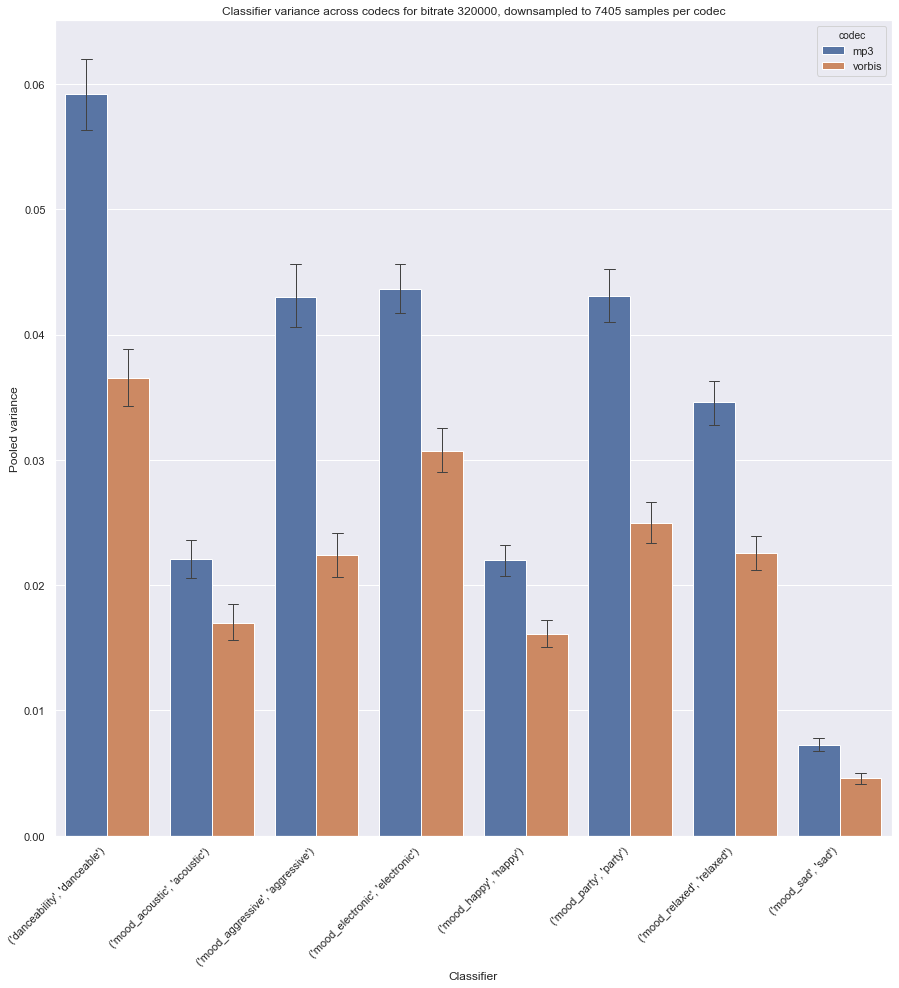

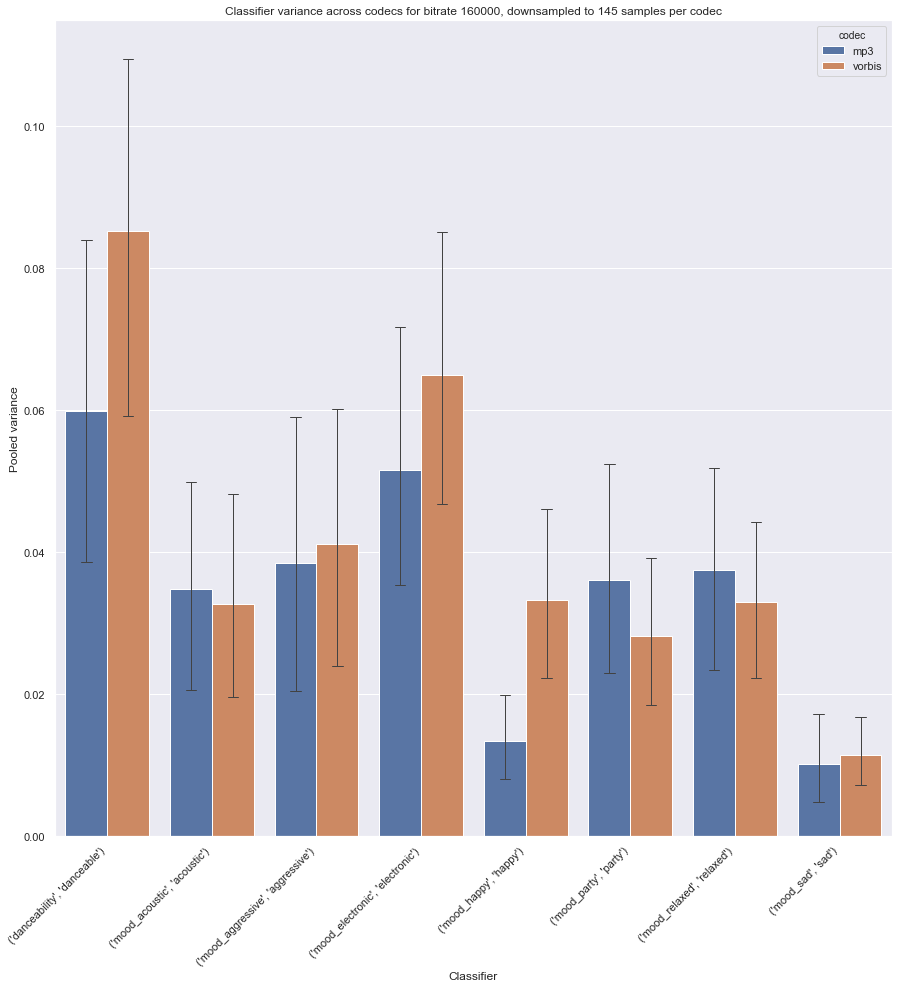

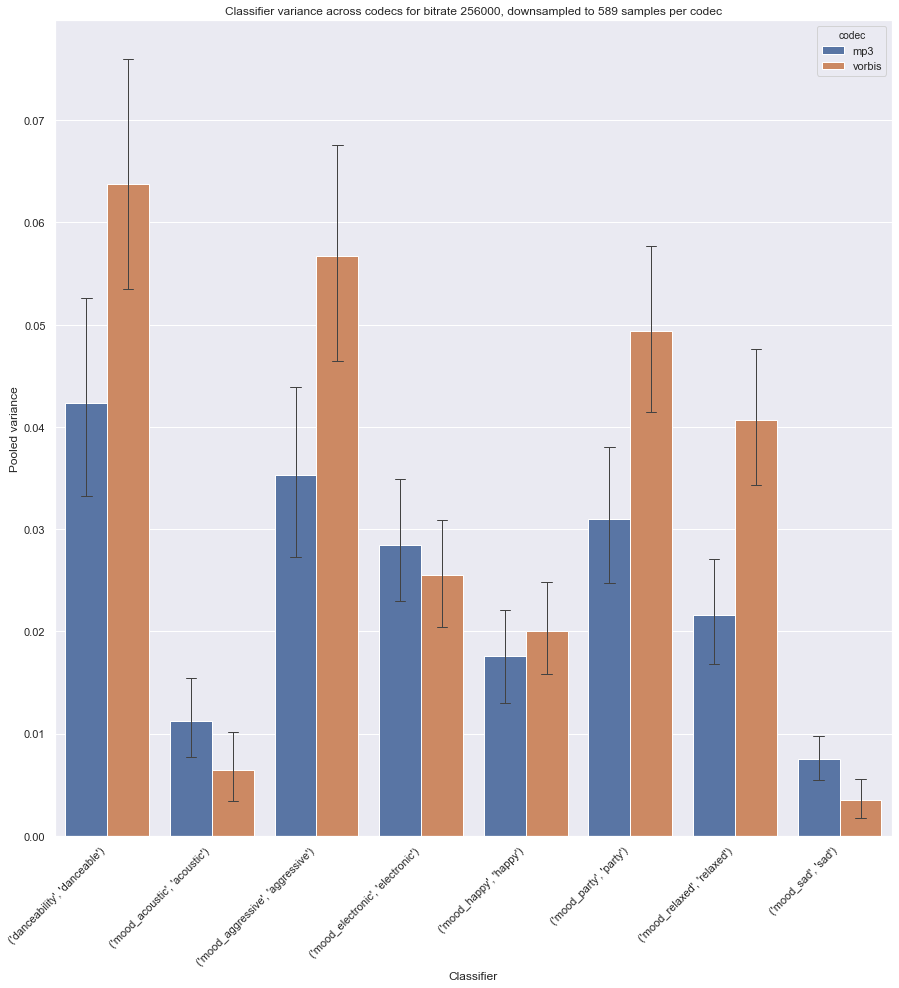

In [92]:
# Get list of common bitrates
bitrates = list(acousticbrainz['bit_rate'].value_counts()[acousticbrainz['bit_rate'].value_counts() > 10000].index)

cols = [('danceability', 'danceable'), ('mood_acoustic', 'acoustic'), ('mood_aggressive', 'aggressive'),
('mood_electronic', 'electronic'), ('mood_happy', 'happy'), ('mood_party', 'party'),
('mood_relaxed', 'relaxed'), ('mood_sad', 'sad')]



for rate in bitrates:
    # Filter by bitrate 
    filtered = acousticbrainz[acousticbrainz['bit_rate'] == rate]
    
    # Remove codecs with n < 200
    filtered = filtered.groupby('codec').filter(lambda x: len(x) >= 200)
    
    # Remove recordings with only one submission
    filt = filtered.groupby(level=0).size() > 1
    filtered = filtered[filt[filtered.index.get_level_values(level=0)].values]  
    
    # Get lowest n for codec so that we can downsample to make n equal across codecs
    n = filtered['codec'].value_counts().min()
    
    # Calculate variances
    variances = filtered[cols].apply(get_variance)
    
    # Add codec column
    variances['codec'] = filtered['codec'].values

    # Downsample
    sampled = variances.groupby('codec').apply(lambda x: x.sample(n))
    
    
    ### PLOTTING ###
    
    toplot = sampled.reset_index(drop=True)
    toplot = toplot.unstack().unstack().transpose()
    toplot = pd.melt(toplot, id_vars=['codec'])
    
    plt.figure()
    ax = sns.barplot(x='variable', y='value', hue='codec', data=toplot, ci=95, errwidth=1, capsize=.1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.title(f"Classifier variance across codecs for bitrate {rate}, downsampled to {n} samples per codec")
    plt.xlabel('Classifier')
    plt.ylabel('Pooled variance')
    plt.show()

And how do bitrate and codec affect the correlation with the spotify data?

In [93]:
from scipy import stats

# Load in mapping and spotify data
mapping = pd.read_hdf(Path.cwd() / 'datasets' / 'mapping.h5')
spotify = pd.read_hdf(Path.cwd() / 'datasets' / 'spotify.h5')

# https://zhiyzuo.github.io/Pearson-Correlation-CI-in-Python/
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

# Define correlations to study
cols = [
    ('acousticness', ('mood_acoustic', 'acoustic')),
    ('danceability', ('danceability', 'danceable')),
    ('energy', ('mood_relaxed', 'not_relaxed')),
    ('instrumentalness', ('voice_instrumental', 'instrumental')),
    ('valence', ('mood_happy', 'happy')),
    ('valence', ('mood_sad', 'not_sad'))
]

# Get the correlations
def get_correlations(data, columns):
    corrs = {
        'classifier': [],
        'correlation': [],
        'p': [],
        'low': [],
        'high': []
    }
    for t in columns:
        corrs['classifier'].append(f"{t[0]} : {t[1]}")
        pearson_r = pearsonr_ci(data[t[0]], data[t[1]])
        corrs['correlation'].append(pearson_r[0])
        corrs['p'].append(pearson_r[1])
        corrs['low'].append(pearson_r[2])
        corrs['high'].append(pearson_r[3])
    return pd.DataFrame(corrs)

# Explicitly add mbid column to make merge possible
acousticbrainz['mbid'] = acousticbrainz.index.get_level_values(0)
merged = acousticbrainz.merge(mapping, on='mbid').merge(spotify, left_on='spotify', right_on='id')



correlation  \
bitrate classifier                                                        
448000  valence : ('mood_sad', 'not_sad')                      0.253805   
        valence : ('mood_happy', 'happy')                      0.319434   
        instrumentalness : ('voice_instrumental', 'inst...     0.442819   
        energy : ('mood_relaxed', 'not_relaxed')               0.591382   
        danceability : ('danceability', 'danceable')           0.337268   
        acousticness : ('mood_acoustic', 'acoustic')           0.743709   
320000  valence : ('mood_sad', 'not_sad')                      0.050631   
        valence : ('mood_happy', 'happy')                      0.197193   
        instrumentalness : ('voice_instrumental', 'inst...     0.255347   
        energy : ('mood_relaxed', 'not_relaxed')               0.377764   
        danceability : ('danceability', 'danceable')           0.296869   
        acousticness : ('mood_acoustic', 'acoustic')           0.670179   
256000  valence : ('mood_sad', 'not_sad')                     -0.094058   
        valence : ('mood_happy', 'happy')                      0.261975   
        instrumentalness : ('voice_instrumental', 'inst...     0.068804   
        energy : ('mood_relaxed', 'not_relaxed')               0.504075   
        danceability : ('danceability', 'danceable')           0.040660   
        acousticness : ('mood_acoustic', 'acoustic')           0.634159   
192000  valence : ('mood_sad', 'not_sad')                      0.128882   
        valence : ('mood_happy', 'happy')                      0.198142   
        instrumentalness : ('voice_instrumental', 'inst...     0.256714   
        energy : ('mood_relaxed', 'not_relaxed')               0.368992   
        danceability : ('danceability', 'danceable')           0.260703   
        acousticness : ('mood_acoustic', 'acoustic')           0.589482   
160000  valence : ('mood_sad', 'not_sad')                      0.110540   
        valence : ('mood_happy', 'happy')                      0.231516   
        instrumentalness : ('voice_instrumental', 'inst...     0.272531   
        energy : ('mood_relaxed', 'not_relaxed')               0.444428   
        danceability : ('danceability', 'danceable')           0.262184   
        acousticness : ('mood_acoustic', 'acoustic')           0.573389   
128000  valence : ('mood_sad', 'not_sad')                      0.124316   
        valence : ('mood_happy', 'happy')                      0.230036   
        instrumentalness : ('voice_instrumental', 'inst...     0.250611   
        energy : ('mood_relaxed', 'not_relaxed')               0.363422   
        danceability : ('danceability', 'danceable')           0.214128   
        acousticness : ('mood_acoustic', 'acoustic')           0.546922   

                                                                        p  \
bitrate classifier                                                          
448000  valence : ('mood_sad', 'not_sad')                    0.000000e+00   
        valence : ('mood_happy', 'happy')                    0.000000e+00   
        instrumentalness : ('voice_instrumental', 'inst...   0.000000e+00   
        energy : ('mood_relaxed', 'not_relaxed')             0.000000e+00   
        danceability : ('danceability', 'danceable')         0.000000e+00   
        acousticness : ('mood_acoustic', 'acoustic')         0.000000e+00   
320000  valence : ('mood_sad', 'not_sad')                    2.299317e-15   
        valence : ('mood_happy', 'happy')                   5.364755e-213   
        instrumentalness : ('voice_instrumental', 'inst...   0.000000e+00   
        energy : ('mood_relaxed', 'not_relaxed')             0.000000e+00   
        danceability : ('danceability', 'danceable')         0.000000e+00   
        acousticness : ('mood_acoustic', 'acoustic')         0.000000e+00   
256000  valence : ('mood_sad', 'not_sad')                    2.343897e-12   
        valence : ('mood_happy', 'happy')             

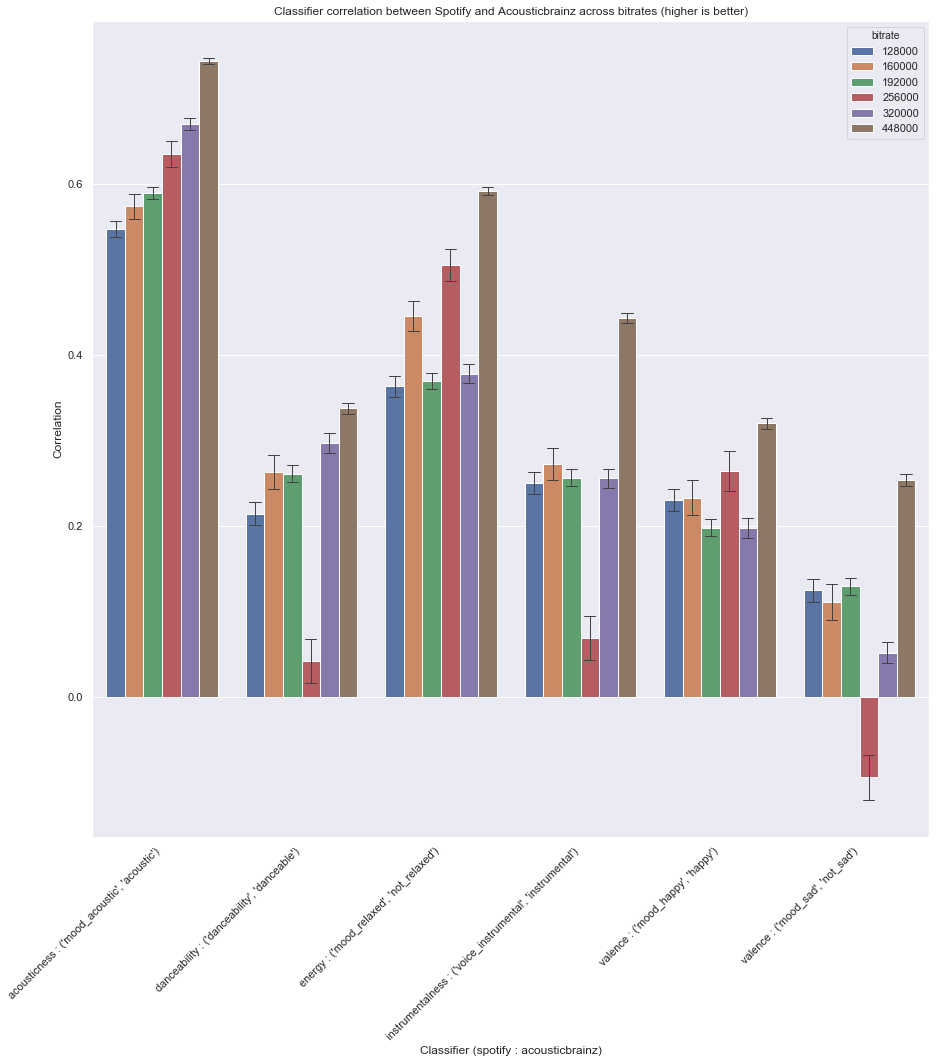

In [94]:
# Effect of bitrate
toplot = pd.DataFrame()
for rate in bitrates:
    filtered = merged[merged['bit_rate'] == rate]
    corrs = get_correlations(filtered, cols)
    
    if rate == 0:
        rate = 448000
    corrs['bitrate'] = rate
    toplot = toplot.append(corrs, ignore_index=True)
    
display(toplot.set_index(keys=['bitrate', 'classifier']).sort_index(ascending=False))

toplot['yerr'] = toplot['high'] - toplot['correlation']

#duplicate observations to get good std bars
dfCopy = toplot.copy()
duplicates = 1000 # increase this number to increase precision
for index, row in toplot.iterrows():
    for times in range(duplicates):
        new_row = row.copy()
        new_row['correlation'] = np.random.normal(row['correlation'],row['yerr']) 
        dfCopy = dfCopy.append(new_row, ignore_index=True)

# Now Seaborn does the rest
plt.figure()
ax = sns.barplot(x='classifier',
                  y='correlation',
                  hue='bitrate',
                  ci='sd',
                  data=dfCopy,
                  errwidth=1, 
                  capsize=.08)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title(f"Classifier correlation between Spotify and Acousticbrainz across bitrates (higher is better)")
plt.xlabel('Classifier (spotify : acousticbrainz)')
plt.ylabel('Correlation')
plt.show()

And how does the codec for the same bitrate affect the correlation between acousticbrainz and spotify data?

Bitrate 192000:


correlation  \
codec  classifier                                                        
mp3    acousticness : ('mood_acoustic', 'acoustic')           0.547438   
       danceability : ('danceability', 'danceable')           0.241005   
       energy : ('mood_relaxed', 'not_relaxed')               0.247527   
       instrumentalness : ('voice_instrumental', 'inst...     0.276432   
       valence : ('mood_happy', 'happy')                      0.183867   
       valence : ('mood_sad', 'not_sad')                      0.058513   
vorbis acousticness : ('mood_acoustic', 'acoustic')           0.518555   
       danceability : ('danceability', 'danceable')          -0.062177   
       energy : ('mood_relaxed', 'not_relaxed')               0.446066   
       instrumentalness : ('voice_instrumental', 'inst...    -0.065867   
       valence : ('mood_happy', 'happy')                     -0.006749   
       valence : ('mood_sad', 'not_sad')                      0.297878   

                                                                      p  \
codec  classifier                                                         
mp3    acousticness : ('mood_acoustic', 'acoustic')        1.295924e-42   
       danceability : ('danceability', 'danceable')        2.051390e-08   
       energy : ('mood_relaxed', 'not_relaxed')            8.205004e-09   
       instrumentalness : ('voice_instrumental', 'inst...  1.024898e-10   
       valence : ('mood_happy', 'happy')                   2.126007e-05   
       valence : ('mood_sad', 'not_sad')                   1.794363e-01   
vorbis acousticness : ('mood_acoustic', 'acoustic')        1.122539e-37   
       danceability : ('danceability', 'danceable')        1.536631e-01   
       energy : ('mood_relaxed', 'not_relaxed')            3.528135e-27   
       instrumentalness : ('voice_instrumental', 'inst...  1.306428e-01   
       valence : ('mood_happy', 'happy')                   8.770553e-01   
       valence : ('mood_sad', 'not_sad')                   2.793583e-12   

                                                                low      high  
codec  classifier                                                              
mp3    acousticness : ('mood_acoustic', 'acoustic')        0.484751  0.604530  
       danceability : ('danceability', 'danceable')        0.158942  0.319761  
       energy : ('mood_relaxed', 'not_relaxed')            0.165695  0.325973  
       instrumentalness : ('voice_instrumental', 'inst...  0.195717  0.353427  
       valence : ('mood_happy', 'happy')                   0.100106  0.265041  
       valence : ('mood_sad', 'not_sad')                  -0.026953  0.143130  
vorbis acousticness : ('mood_acoustic', 'acoustic')        0.453281  0.578298  
       danceability : ('danceability', 'danceable')       -0.146730  0.023278  
       energy : ('mood_relaxed', 'not_relaxed')            0.375008  0.511912  
       instrumentalness : ('voice_instrumental', 'inst... -0.150354  0.019574  
       valence : ('mood_happy', 'happy')                  -0.092027  0.078629  
       valence : ('mood_sad', 'not_sad')                   0.218089  0.373710

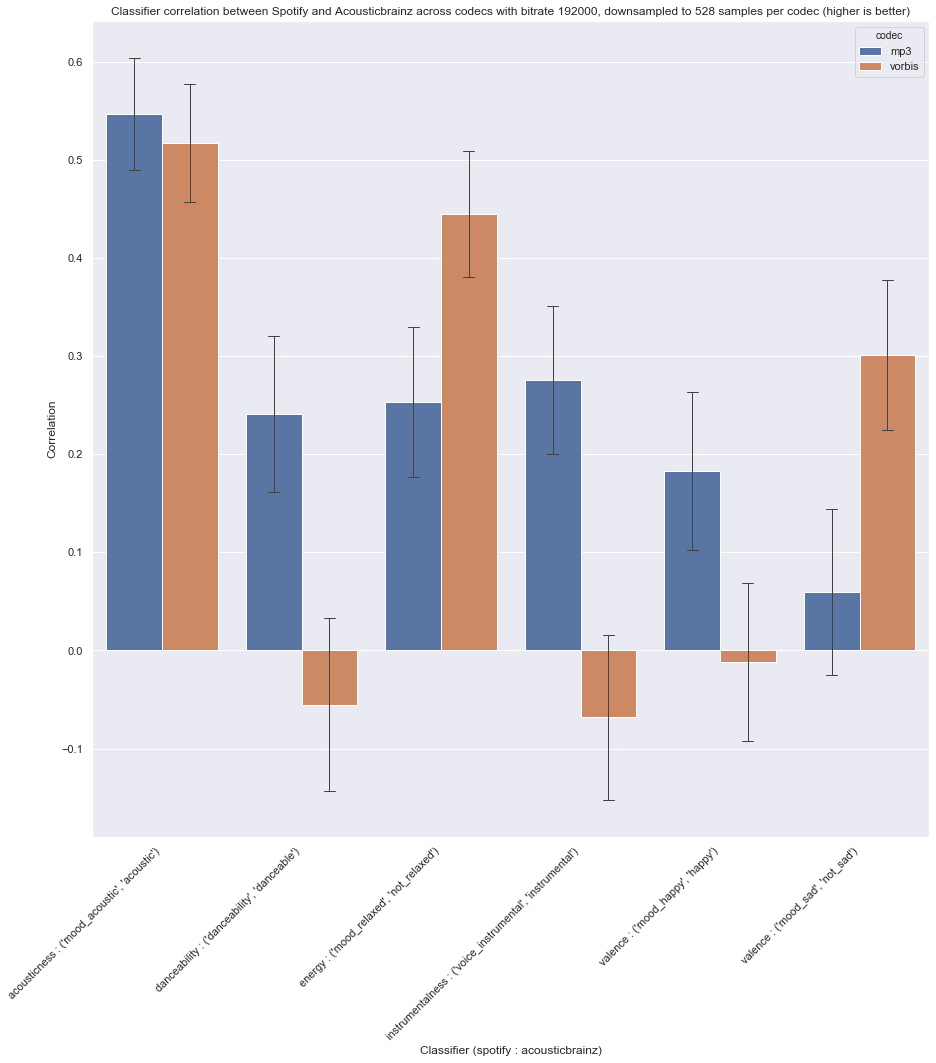

Bitrate 320000:


correlation  \
codec  classifier                                                        
mp3    acousticness : ('mood_acoustic', 'acoustic')           0.562586   
       danceability : ('danceability', 'danceable')           0.279571   
       energy : ('mood_relaxed', 'not_relaxed')               0.329760   
       instrumentalness : ('voice_instrumental', 'inst...     0.169097   
       valence : ('mood_happy', 'happy')                      0.106806   
       valence : ('mood_sad', 'not_sad')                      0.120485   
vorbis acousticness : ('mood_acoustic', 'acoustic')           0.762347   
       danceability : ('danceability', 'danceable')           0.280589   
       energy : ('mood_relaxed', 'not_relaxed')               0.538770   
       instrumentalness : ('voice_instrumental', 'inst...     0.450092   
       valence : ('mood_happy', 'happy')                      0.292821   
       valence : ('mood_sad', 'not_sad')                      0.116583   

                                                                       p  \
codec  classifier                                                          
mp3    acousticness : ('mood_acoustic', 'acoustic')         0.000000e+00   
       danceability : ('danceability', 'danceable')        8.042990e-131   
       energy : ('mood_relaxed', 'not_relaxed')            3.272419e-184   
       instrumentalness : ('voice_instrumental', 'inst...   7.813059e-48   
       valence : ('mood_happy', 'happy')                    6.385024e-20   
       valence : ('mood_sad', 'not_sad')                    5.965546e-25   
vorbis acousticness : ('mood_acoustic', 'acoustic')         0.000000e+00   
       danceability : ('danceability', 'danceable')        8.423121e-132   
       energy : ('mood_relaxed', 'not_relaxed')             0.000000e+00   
       instrumentalness : ('voice_instrumental', 'inst...   0.000000e+00   
       valence : ('mood_happy', 'happy')                   6.744854e-144   
       valence : ('mood_sad', 'not_sad')                    1.872567e-23   

                                                                low      high  
codec  classifier                                                              
mp3    acousticness : ('mood_acoustic', 'acoustic')        0.546679  0.578087  
       danceability : ('danceability', 'danceable')        0.258258  0.300612  
       energy : ('mood_relaxed', 'not_relaxed')            0.309130  0.350080  
       instrumentalness : ('voice_instrumental', 'inst...  0.146695  0.191325  
       valence : ('mood_happy', 'happy')                   0.084041  0.129460  
       valence : ('mood_sad', 'not_sad')                   0.097784  0.143061  
vorbis acousticness : ('mood_acoustic', 'acoustic')        0.752555  0.771803  
       danceability : ('danceability', 'danceable')        0.259289  0.301617  
       energy : ('mood_relaxed', 'not_relaxed')            0.522262  0.554874  
       instrumentalness : ('voice_instrumental', 'inst...  0.431582  0.468223  
       valence : ('mood_happy', 'happy')                   0.271677  0.313683  
       valence : ('mood_sad', 'not_sad')                   0.093863  0.139183

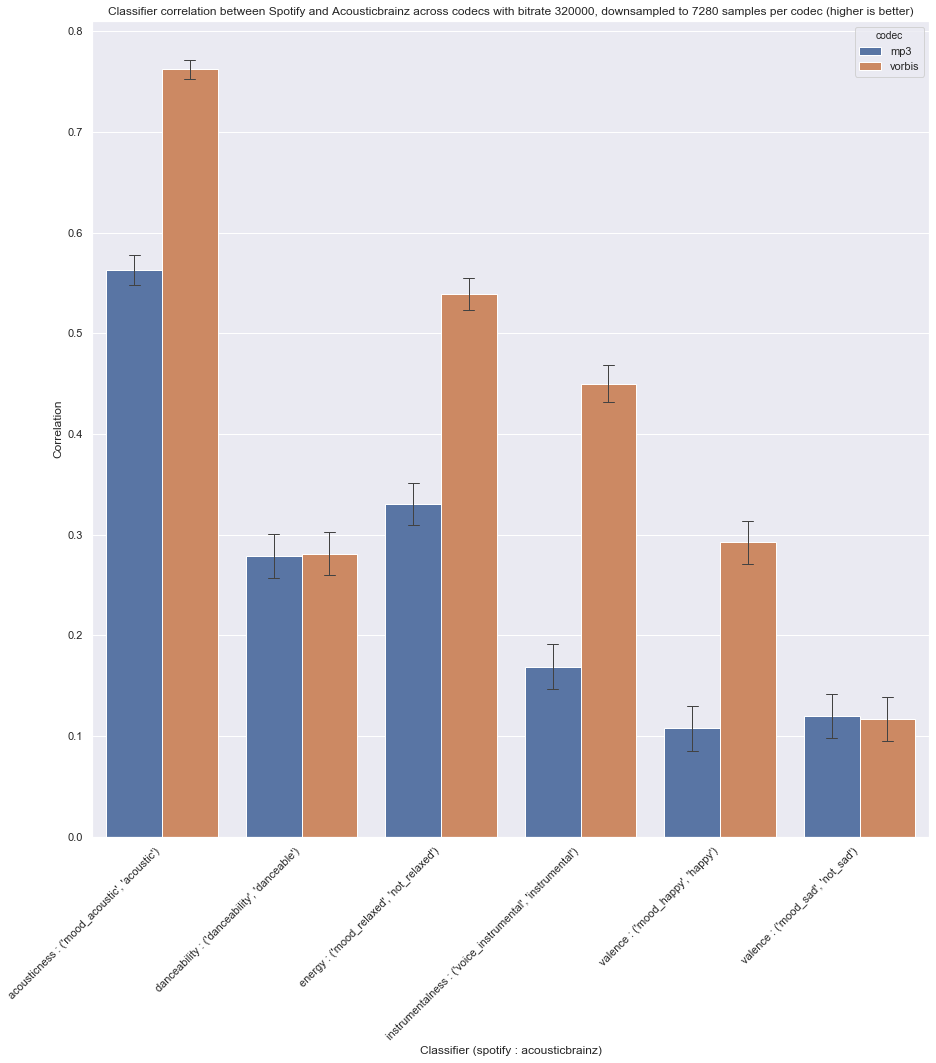

Bitrate 160000:


correlation  \
codec  classifier                                                        
mp3    acousticness : ('mood_acoustic', 'acoustic')           0.582858   
       danceability : ('danceability', 'danceable')           0.309959   
       energy : ('mood_relaxed', 'not_relaxed')               0.451977   
       instrumentalness : ('voice_instrumental', 'inst...     0.312306   
       valence : ('mood_happy', 'happy')                      0.205961   
       valence : ('mood_sad', 'not_sad')                      0.155913   
vorbis acousticness : ('mood_acoustic', 'acoustic')           0.427185   
       danceability : ('danceability', 'danceable')           0.223683   
       energy : ('mood_relaxed', 'not_relaxed')               0.507675   
       instrumentalness : ('voice_instrumental', 'inst...     0.013231   
       valence : ('mood_happy', 'happy')                      0.154805   
       valence : ('mood_sad', 'not_sad')                      0.005898   

                                                                      p  \
codec  classifier                                                         
mp3    acousticness : ('mood_acoustic', 'acoustic')        3.557880e-51   
       danceability : ('danceability', 'danceable')        1.145164e-13   
       energy : ('mood_relaxed', 'not_relaxed')            6.053575e-29   
       instrumentalness : ('voice_instrumental', 'inst...  7.310857e-14   
       valence : ('mood_happy', 'happy')                   1.158262e-06   
       valence : ('mood_sad', 'not_sad')                   2.483769e-04   
vorbis acousticness : ('mood_acoustic', 'acoustic')        1.023514e-25   
       danceability : ('danceability', 'danceable')        1.213016e-07   
       energy : ('mood_relaxed', 'not_relaxed')            3.076144e-37   
       instrumentalness : ('voice_instrumental', 'inst...  7.572919e-01   
       valence : ('mood_happy', 'happy')                   2.752220e-04   
       valence : ('mood_sad', 'not_sad')                   8.904314e-01   

                                                                low      high  
codec  classifier                                                              
mp3    acousticness : ('mood_acoustic', 'acoustic')        0.524716  0.635588  
       danceability : ('danceability', 'danceable')        0.232229  0.383755  
       energy : ('mood_relaxed', 'not_relaxed')            0.382707  0.516195  
       instrumentalness : ('voice_instrumental', 'inst...  0.234687  0.385969  
       valence : ('mood_happy', 'happy')                   0.124347  0.284807  
       valence : ('mood_sad', 'not_sad')                   0.073109  0.236582  
vorbis acousticness : ('mood_acoustic', 'acoustic')        0.356170  0.493294  
       danceability : ('danceability', 'danceable')        0.142596  0.301788  
       energy : ('mood_relaxed', 'not_relaxed')            0.442743  0.567311  
       instrumentalness : ('voice_instrumental', 'inst... -0.070606  0.096883  
       valence : ('mood_happy', 'happy')                   0.071979  0.235510  
       valence : ('mood_sad', 'not_sad')                  -0.077899  0.089613

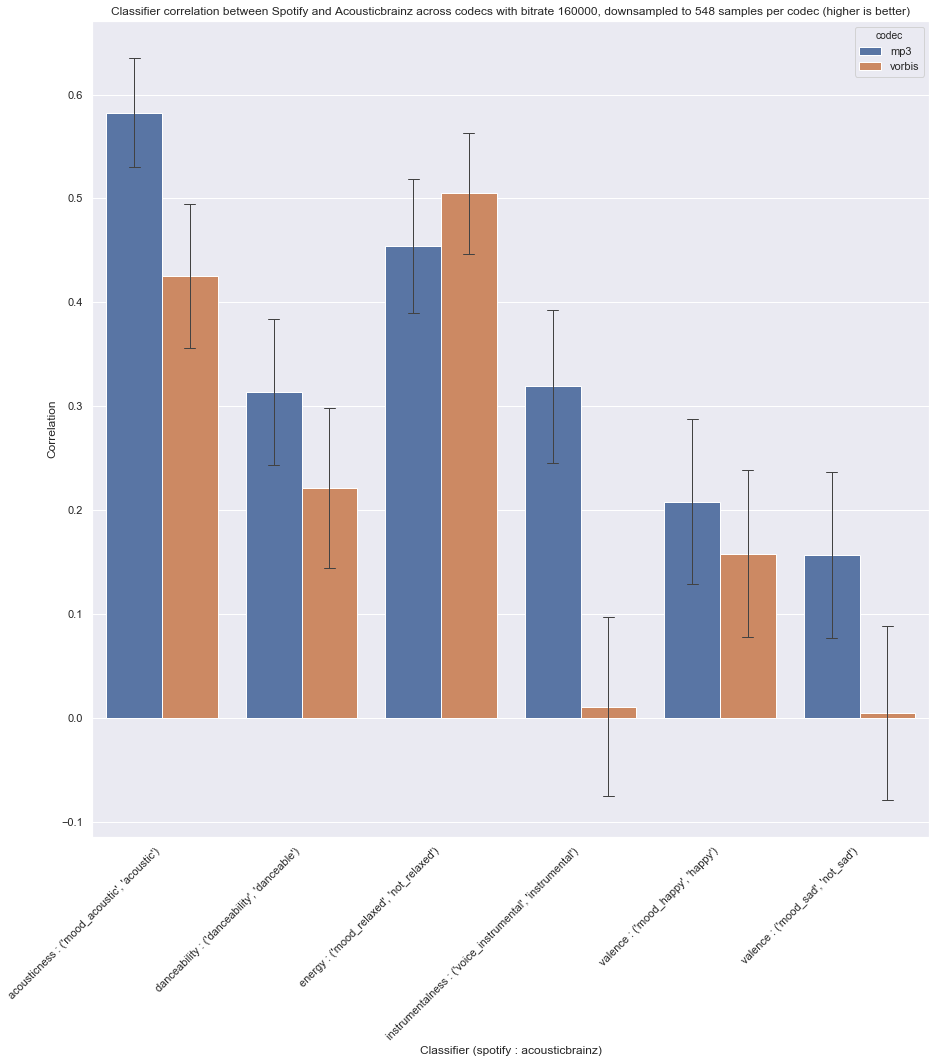

Bitrate 256000:


correlation  \
codec  classifier                                                        
mp3    acousticness : ('mood_acoustic', 'acoustic')           0.578002   
       danceability : ('danceability', 'danceable')           0.220517   
       energy : ('mood_relaxed', 'not_relaxed')               0.414828   
       instrumentalness : ('voice_instrumental', 'inst...     0.205845   
       valence : ('mood_happy', 'happy')                      0.234026   
       valence : ('mood_sad', 'not_sad')                      0.137228   
vorbis acousticness : ('mood_acoustic', 'acoustic')           0.691514   
       danceability : ('danceability', 'danceable')           0.156174   
       energy : ('mood_relaxed', 'not_relaxed')               0.487232   
       instrumentalness : ('voice_instrumental', 'inst...     0.172543   
       valence : ('mood_happy', 'happy')                      0.229062   
       valence : ('mood_sad', 'not_sad')                     -0.208755   

                                                                       p  \
codec  classifier                                                          
mp3    acousticness : ('mood_acoustic', 'acoustic')        7.757412e-223   
       danceability : ('danceability', 'danceable')         6.546745e-29   
       energy : ('mood_relaxed', 'not_relaxed')            1.414029e-104   
       instrumentalness : ('voice_instrumental', 'inst...   2.514452e-25   
       valence : ('mood_happy', 'happy')                    1.898148e-32   
       valence : ('mood_sad', 'not_sad')                    5.556231e-12   
vorbis acousticness : ('mood_acoustic', 'acoustic')         0.000000e+00   
       danceability : ('danceability', 'danceable')         4.060987e-15   
       energy : ('mood_relaxed', 'not_relaxed')            3.213603e-149   
       instrumentalness : ('voice_instrumental', 'inst...   3.686580e-18   
       valence : ('mood_happy', 'happy')                    4.027890e-31   
       valence : ('mood_sad', 'not_sad')                    5.135533e-26   

                                                                low      high  
codec  classifier                                                              
mp3    acousticness : ('mood_acoustic', 'acoustic')        0.551291  0.603529  
       danceability : ('danceability', 'danceable')        0.182896  0.257494  
       energy : ('mood_relaxed', 'not_relaxed')            0.381835  0.446765  
       instrumentalness : ('voice_instrumental', 'inst...  0.167998  0.243086  
       valence : ('mood_happy', 'happy')                   0.196627  0.270745  
       valence : ('mood_sad', 'not_sad')                   0.098555  0.175487  
vorbis acousticness : ('mood_acoustic', 'acoustic')        0.670487  0.711430  
       danceability : ('danceability', 'danceable')        0.117692  0.194188  
       energy : ('mood_relaxed', 'not_relaxed')            0.456754  0.516568  
       instrumentalness : ('voice_instrumental', 'inst...  0.134248  0.210323  
       valence : ('mood_happy', 'happy')                   0.191579  0.265877  
       valence : ('mood_sad', 'not_sad')                  -0.245945 -0.170952

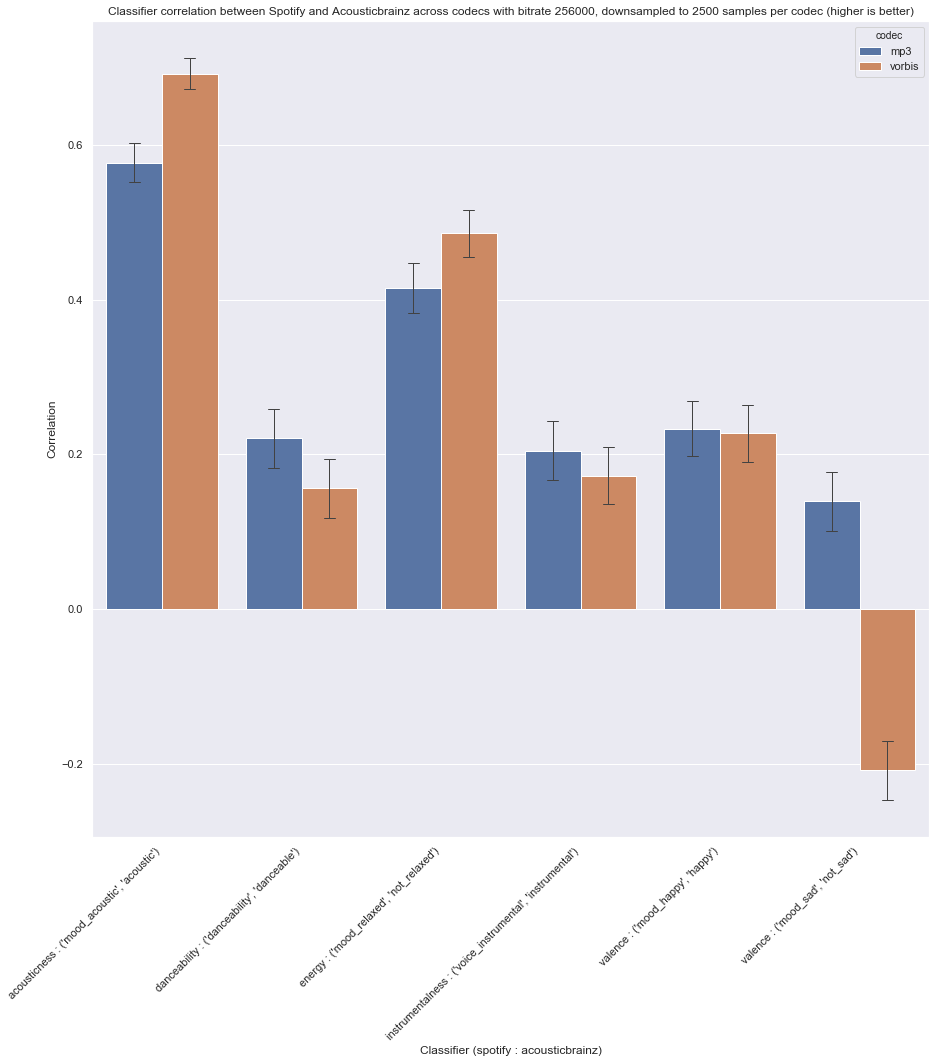

In [95]:
for rate in bitrates:
    # Filter on bitrate
    filtered = merged[merged['bit_rate'] == rate]
    
    # Remove codecs with n < 200
    filtered = filtered.groupby('codec').filter(lambda x: len(x) >= 200) 
    
    # Get lowest n for codec so that we can downsample to make n equal across codecs
    n = filtered['codec'].value_counts().min()
    
    # Only if we have at least two codecs in the data can we make the comparison
    if len(filtered['codec'].value_counts()) > 1:
        print(f"Bitrate {rate}:")
        
        # Downsample so groups are equal
        filtered = filtered.groupby('codec').apply(lambda x: x.sample(n))
        
        # Calculate correlations per codec
        corrs = filtered.groupby(level=0).apply(lambda x: get_correlations(x, cols))
        display(corrs.droplevel(level=1).set_index(['classifier'], append=True))
        corrs = corrs.reset_index()
        
        corrs['yerr'] = corrs['high'] - corrs['correlation']

        #duplicate observations to get good std bars
        dfCopy = corrs.copy()
        duplicates = 1000 # increase this number to increase precision
        for index, row in corrs.iterrows():
            for times in range(duplicates):
                new_row = row.copy()
                new_row['correlation'] = np.random.normal(row['correlation'],row['yerr']) 
                dfCopy = dfCopy.append(new_row, ignore_index=True)

        # Now Seaborn does the rest
        plt.figure()
        ax = sns.barplot(x='classifier',
                          y='correlation',
                          hue='codec',
                          ci='sd',
                          data=dfCopy,
                          errwidth=1, 
                          capsize=.08)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        plt.title(f"Classifier correlation between Spotify and Acousticbrainz across codecs with bitrate {rate}, downsampled to {n} samples per codec (higher is better)")
        plt.xlabel('Classifier (spotify : acousticbrainz)')
        plt.ylabel('Correlation')
        plt.show()
        